<a href="https://colab.research.google.com/github/mcany-pia/defect-categorization/blob/main/Defects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 28.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Initially used numpy for reading csv but it gave error at line 38 because there was a comma. So i guess it is not for reading text. therefore used pandas.

In [46]:
# train data
vdf = pd.read_csv("more-defects.csv")
# test data
#tdf = pd.read_csv('CompleteDataset.csv', sep="|")
#tdf = tdf.sample(frac = 1, random_state=2).reset_index()
#print(tdf.head)
#Shuffling and splitting the dataset into 70% training and 30% testing
#tdf = tdf.groupby('super').apply(lambda x: x.sample(n=250)).reset_index(drop=True)

tdf, vdf = train_test_split(vdf, test_size=0.2, random_state=42, shuffle=True)

#tdf = vdf.iloc[:700]
#vdf = vdf.iloc[700:]



print(vdf.head)
print(tdf.head)

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2


<bound method NDFrame.head of                                                 Summary Ambiguous Description  \
168         ACMUI - GET request is using incorrect URL.                    no   
605       PAM UI does not show saved language correctly                    no   
548   DGAMS: geographicSubAddress GET request is suc...                    no   
65    PC-UI: Setting the Mandatory value incorrectly...                    no   
628                     Future dated order not starting                   yes   
...                                                 ...                   ...   
1367  RC UI does not refresh token after logging in,...                   NaN   
265   DRCMS-UI: 404 error in Resource Specifications...                    no   
1425  Basit düzeyde findById yapmak istedigimizde db...                   NaN   
493          F2251401 NAZMI HOTI  Device change failed                    yes   
1340        PC - adding service specification 400 error                   NaN  

Get number of samples and words per sample to compare. Then using https://developers.google.com/machine-learning/guides/text-classification/step-2-5 decide to the model.

In [ ]:
rows = len(df)
total_words = df['summary'].apply(lambda x: len(str(x).split())).sum()
w_per_s = total_words / rows
w_per_s

10.276476471207495

Since it is less than 1500 we are going with MLP.

In [ ]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

Berfore we fed model with data. We should tokenize. Then train with it.

In [55]:
# Define train_texts, train_labels, val_texts, and val_labels earlier
train_texts = tdf['Summary']
train_labels = tdf['Merged Classification']
val_texts = vdf['Summary']
val_labels = vdf['Merged Classification']
# Initialize a label encoder
label_encoder = LabelEncoder()

# Vectorize the texts using the function
x_train, x_val = ngram_vectorize(train_texts, train_labels, val_texts)
# Fit the encoder on the training labels and transform both train and validation labels
y_train_encoded = label_encoder.fit_transform(train_labels)
y_val_encoded = label_encoder.transform(val_labels)

unique_classes = np.unique(train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2065: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


MLP:

In [ ]:

# Initialize the MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(50), max_iter=100, activation='relu', solver='adam', random_state=42)



cross_val_accuracies = cross_val_score(mlp_clf, x_train, y_train_encoded, cv=5, scoring='accuracy')

# Compute mean and standard deviation of cross-validation accuracies
mean_cross_val_accuracy = cross_val_accuracies.mean()
std_cross_val_accuracy = cross_val_accuracies.std()
print("Cross-Validation Accuracies:", cross_val_accuracies)
print(mean_cross_val_accuracy)
print(std_cross_val_accuracy)


# Train the model
mlp_clf.fit(x_train, y_train_encoded)

# Predict on the validation set
y_val_pred_mlp = mlp_clf.predict(x_val)

# Calculate the accuracy
training_score = mlp_clf.score(x_train, y_train_encoded)
print("Training Score (Accuracy):", training_score)


accuracy_mlp = accuracy_score(y_val_encoded, y_val_pred_mlp, normalize=True)
cm = confusion_matrix(y_val_encoded, y_val_pred_mlp)
fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
fig.plot()
plt.show()

print(classification_report(y_val_encoded, y_val_pred_mlp))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Op

Cross-Validation Accuracies: [0.85052632 0.87157895 0.86421053 0.87368421 0.87473684]
0.8669473684210527
0.008996151839672213
Training Score (Accuracy): 1.0


NameError: ignored

SVM:
Top 3
Synthetic = 0.62
Real = 0.82

With more defects it using real data accuracy drops to 0.62

Cross-Validation Accuracies: [0.54978355 0.53679654 0.58695652 0.55652174 0.53913043]
0.5538377564464521
0.018039963674605194
Top-3 Accuracy on validation set: 0.8541666666666666
                       precision    recall  f1-score   support

    Algorithmic Error       0.00      0.00      0.00         2
          Build Error       0.71      0.52      0.60        23
Data Management Error       0.46      0.67      0.55        63
    Integration Error       0.50      0.08      0.14        12
       Patching Error       0.58      0.54      0.56        13
    Performance Error       1.00      0.25      0.40        12
       Security Error       0.90      0.72      0.80        39
         System Error       0.75      0.43      0.55         7
             UI Error       0.68      0.81      0.74        37
     Validation Error       0.59      0.69      0.64        70
     Verfigback Error       0.67      0.20      0.31        10

             accuracy                           0.61       288


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


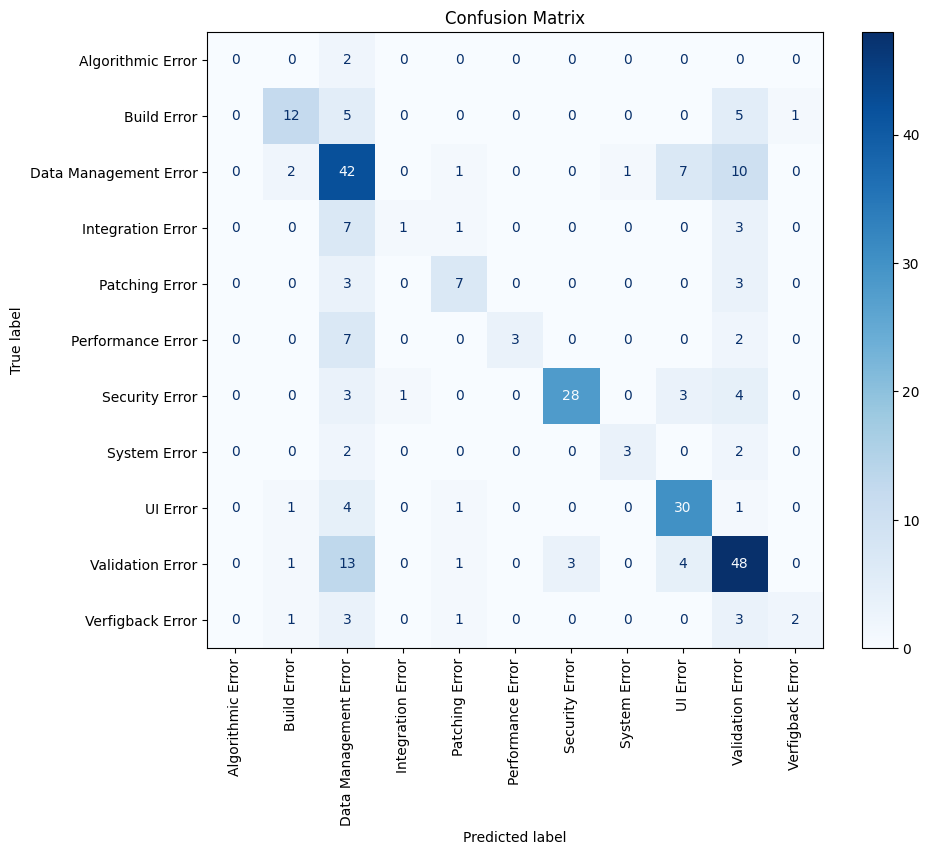

In [66]:
svm = SVC(kernel='linear', random_state=42, probability=True)
svm.fit(x_train, y_train_encoded)
y_val_prob_svm = svm.predict_proba(x_val)

# Get the top 3 predicted classes for each instance
top3_preds = np.argsort(y_val_prob_svm, axis=1)[:, -3:]

# Check if true label is in top 3 predictions for each instance
top3_accuracy = np.mean([y_val_encoded[i] in top3_preds[i] for i in range(len(y_val_encoded))])

cross_val_accuracies = cross_val_score(svm, x_train, y_train_encoded, cv=5, scoring='accuracy')

# Compute mean and standard deviation of cross-validation accuracies
mean_cross_val_accuracy = cross_val_accuracies.mean()
std_cross_val_accuracy = cross_val_accuracies.std()

print("Cross-Validation Accuracies:", cross_val_accuracies)
print(mean_cross_val_accuracy)
print(std_cross_val_accuracy)

print("Top-3 Accuracy on validation set:", top3_accuracy)

# If you still want the standard predictions and classification report:
y_val_pred_svm = svm.predict(x_val)
classification_rep_svm_test_new = classification_report(y_val_encoded, y_val_pred_svm, target_names=label_encoder.classes_)
print(classification_rep_svm_test_new)

cm = confusion_matrix(y_val_encoded, y_val_pred_svm)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot(ax=ax, cmap=plt.cm.Blues)

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.title('Confusion Matrix')
plt.show()


GBDT:

In [ ]:
# Initializing and training the GBDT classifier
gbdt_classifier = GradientBoostingClassifier(random_state=42)
gbdt_classifier.fit(x_train, y_train_encoded)

# Predicting on the test set
y_test_pred_gbdt = gbdt_classifier.predict(x_val)

# Calculating accuracy and classification report for the GBDT model
classification_rep_gbdt_test = classification_report(y_val_encoded, y_test_pred_gbdt)
print(classification_rep_gbdt_test)


0.33716075156576203
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.44      0.31      0.36        55
           2       0.00      0.00      0.00         6
           3       0.69      0.12      0.21       160
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         3
           6       0.07      0.24      0.11        17
           7       1.00      0.27      0.43        11
           8       0.88      0.93      0.90        15
           9       0.37      0.86      0.52        44
          10       0.22      0.58      0.32        53
          11       0.08      0.83      0.15         6
          12       0.39      0.49      0.44        79
          13       0.05      0.25      0.09         8
          14       0.33      0.15      0.21        39
          15       0.78      1.00      0.88         7
          16       0.58      0.58      0.58       173
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.